In [1]:
## ========================= Problem 1 =================================== ##

import numpy as np
import math
import statsmodels.api as sm
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

## ========================== Parameter Declaration ========================== ##

window_size = 100 # t
filter_order = 5
alpha = 1.5
lamda = 1

## =========================== Generate Sampeles =========================== ##

# Samples of input-output pairs
sample_size = 10000
# sample_index = np.linspace(0, 1, sample_size+10)
# filter_x = [math.exp(-lamda * np.power(abs(sample_index[i]), alpha)) for i in range(len(sample_index))] # from the 10th

# mean, var, skew, kurt = levy_stable.stats(alpha = alpha, c = lamda, moments='mvsk')

filter_x = levy_stable.rvs(alpha = alpha, beta = 0, size = sample_size + 10)


# The input to the plant
filter_y = np.zeros((sample_size))
for i in range (9, sample_size + 9):
    filter_y[i-9] = np.sum(filter_x[i-9:i+1]) # actual value
    
# filter_input_x = filter_x[10:sample_size+10]
filter_input_x = filter_x[10:sample_size+10]
filter_output_y = filter_y.copy()

# Generate white noise
mu = 0
sigma = 0.1
filter_noise = np.random.normal(mu, sigma, sample_size)

# Output of the filter
filter_output_noise_y = filter_output_y + filter_noise

Text(0, 0.5, 'Input to plant')

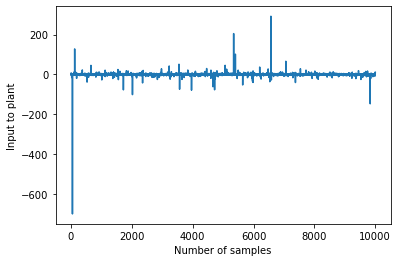

In [2]:
plt.plot(filter_input_x)
plt.xlabel('Number of samples')
plt.ylabel('Input to plant')

Text(0, 0.5, 'Auto-correlation')

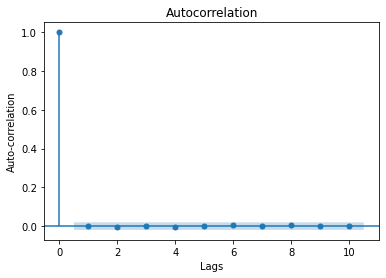

In [3]:
# ACF of input
from statsmodels.graphics import tsaplots

# ACF_of_input = sm.tsa.acf(x = filter_x, nlags = 100)
fig = tsaplots.plot_acf(x = filter_input_x, lags=10)
plt.xlabel('Lags')
plt.ylabel('Auto-correlation')

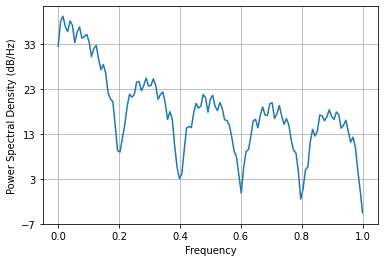

In [4]:
# PSD of output with noise
# fig, ax = plt.subplots(1, 1)
#ax.hist(filter_x, density=True, histtype='stepfilled', alpha=0.2)

# aa = sm.tsa.acf(filter_input_x)
l1 = plt.psd(filter_output_noise_y)
plt.show()

In [5]:
# Wiener Filter
from scipy.linalg import toeplitz
import scipy
from scipy.ndimage.interpolation import shift
# filter_input_x, filter_output_y

filter_order = 15 # 5, 15, 30
window_size = 500 # 100, 500, 1000

window_filter_x = np.array([filter_input_x[filter_order-i:window_size+filter_order-i] for i in range(filter_order)])
window_filter_y = filter_output_noise_y[filter_order:window_size+filter_order]

# ACF
R = np.zeros((filter_order, filter_order))
for i in range (R.shape[0]):
    for j in range (R.shape[1]):
        R[i, j] = np.dot(window_filter_x[i], window_filter_x[j])
print(R)

[[ 5.11420712e+05 -1.13207281e+02 -1.36847486e+03  1.94891966e+03
  -2.10462393e+03  1.26868173e+03  2.42676277e+03 -1.22214931e+03
   2.87800195e+03 -1.25882394e+03  4.10370662e+01 -2.01172347e+02
   2.26265655e+03 -9.72637143e+02  1.17320957e+03]
 [-1.13207281e+02  5.11423728e+05 -1.12397486e+02 -1.36841317e+03
   1.94682781e+03 -2.10621355e+03  1.25664134e+03  2.43270636e+03
  -1.22137746e+03  2.87951296e+03 -1.25836889e+03  3.61047675e+01
  -2.03902888e+02  2.26370350e+03 -9.73212535e+02]
 [-1.36847486e+03 -1.12397486e+02  5.11423811e+05 -1.13025061e+02
  -1.36927289e+03  1.94689742e+03 -2.10983511e+03  1.25740819e+03
   2.43287628e+03 -1.22155892e+03  2.88022807e+03 -1.25628545e+03
   3.42715812e+01 -2.03228559e+02  2.26380306e+03]
 [ 1.94891966e+03 -1.36841317e+03 -1.13025061e+02  5.11420735e+05
  -1.14492009e+02 -1.36693370e+03  1.94479330e+03 -2.11367396e+03
   1.25724575e+03  2.43010194e+03 -1.21871670e+03  2.89640840e+03
  -1.26159717e+03  3.61717764e+01 -2.02026579e+02]
 [-2

In [6]:
# Cross-correlation
from scipy.ndimage.interpolation import shift

P = np.zeros((filter_order))
for i in range (window_filter_x.shape[0]):
    P[i] = np.dot(window_filter_x[i], window_filter_y)
print(P)

[  2582.73329831 513928.60576395 514972.69912268 510815.38938313
 513952.20814652 509275.84556585 509404.38945479 513852.29242213
 510818.28397755 515017.55271447 513904.97045904   2547.22313157
   2473.20517405   6091.03563554   3165.09786756]


In [7]:
hopt = np.matmul(np.linalg.inv(R), P)
np.around(hopt, 3)

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])

In [8]:
# Calculate Weight Accuracy
W_opt = np.zeros((filter_order))
if filter_order <= 10:
    W_opt[:] = 1
else:
    W_opt[0:10] = 1

# WSNR
W_error = W_opt - hopt
WSNR = 10 * math.log10(np.dot(W_opt, W_opt)/np.dot(W_error, W_error))
WSNR

6.990293974641939

(500,)


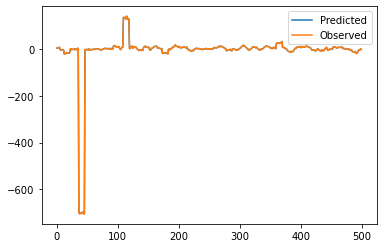

In [9]:
y_hat = np.matmul(hopt, window_filter_x)
print(y_hat.shape)
l1 = plt.plot(y_hat)
l2 = plt.plot(window_filter_y)
plt.legend(['Predicted', 'Observed'])
plt.show()

In [30]:
# LMS Algorithm

import padasip as pa

weight_filter = np.zeros((filter_order))

window_filter_x = np.array([filter_input_x[filter_order-i:filter_input_x.shape[0]-i] for i in range(filter_order)])
window_filter_y = filter_output_noise_y[filter_order:]

mu = 0.000005
n = 0

weight_store = []
error_store = []


while (n <= window_filter_y.shape[0]-1):
    e_n = window_filter_y[n] - np.dot(weight_filter, window_filter_x[:, n])
    weight_filter = weight_filter + mu * window_filter_x[:, n] * e_n
    weight_store.append(weight_filter)
    y_hat = np.matmul(weight_filter, window_filter_x)
    y_error = np.mean((y_hat-window_filter_y) ** 2) / np.sqrt(np.sum(window_filter_y ** 2))
    error_store.append(y_error)
    n = n + 1

w_optimal = weight_filter
print(w_optimal)

# Calculate WSNR
W_error = W_opt - w_optimal
WSNR = 10 * math.log10(np.dot(W_opt, W_opt)/np.dot(W_error, W_error))
WSNR

[-0.00805829  1.25868201  1.25891933  1.26297096  1.26204696  1.26744048
  1.2676178   1.26157629  1.2612786   1.25483607  1.2572452  -0.00918104
 -0.00608142 -0.01579662 -0.01154827]


4.929672458363633

(9985,)


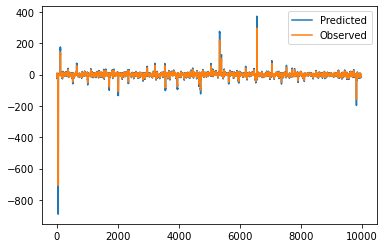

In [31]:
# y_predicted and y_observed
y_hat = np.matmul(w_optimal, window_filter_x)
print(y_hat.shape)
l1 = plt.plot(y_hat)
l2 = plt.plot(window_filter_y)
plt.legend(['Predicted', 'Observed'])
plt.show()

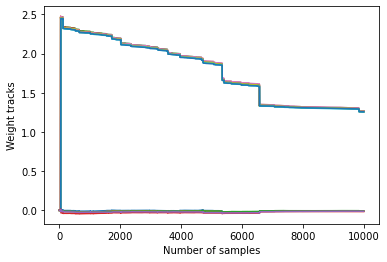

In [32]:
# weight
plt.plot(np.arange(len(weight_store)), weight_store)
plt.xlabel('Number of samples')
plt.ylabel('Weight tracks')
plt.show()

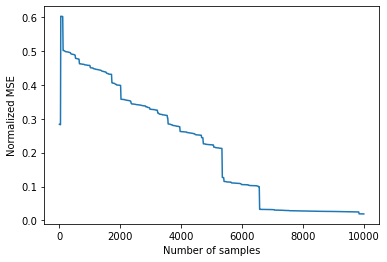

In [33]:
# error
plt.plot(np.arange(len(error_store)), error_store)
plt.xlabel('Number of samples')
plt.ylabel('Normalized MSE')
plt.show()

In [2]:
# RLS Algorithm

filter_order = 15 # 5, 15, 30

weight_filter = np.zeros((filter_order))

window_filter_x = np.array([filter_input_x[filter_order-i:filter_input_x.shape[0]-i] for i in range(filter_order)])
window_filter_y = filter_output_noise_y[filter_order:]

n = 0
delta = 0.001
R_RLS = np.eye(filter_order) * delta

weight_store = []
error_store = []


while (n <= window_filter_y.shape[0]-1):
    e_n = window_filter_y[n] - np.dot(weight_filter, window_filter_x[:, n])
    z_n = np.dot(R_RLS, window_filter_x[:, n])
    q_n = np.dot(window_filter_x[:, n], z_n)
    z_n_normalized = z_n * 1/(1 + q_n + 1e-5)
    weight_filter = weight_filter + z_n_normalized * e_n
    R_RLS = R_RLS - np.matmul(z_n_normalized.reshape(1,-1).T, z_n.reshape(1,-1))
    weight_store.append(weight_filter)
    y_hat = np.matmul(weight_filter, window_filter_x)
    y_error = np.mean((y_hat-window_filter_y) ** 2) / np.sqrt(np.sum(window_filter_y ** 2))
    error_store.append(y_error)
    n = n + 1

w_optimal = weight_filter
print(n)
print(np.around(w_optimal, 3))

# define w_opt
W_opt = np.zeros((filter_order))
if filter_order <= 10:
    W_opt[:] = 1
else:
    W_opt[0:10] = 1

# Calculate WSNR
W_error = W_opt - w_optimal
WSNR = 10 * math.log10(np.dot(W_opt, W_opt)/np.dot(W_error, W_error))
WSNR

9985
[ 2.000e-03  9.930e-01  9.980e-01  9.980e-01  9.920e-01  1.002e+00
  1.000e+00  9.980e-01  1.000e+00  1.000e+00  9.940e-01 -7.000e-03
  0.000e+00  8.000e-03  1.000e-03]


7.022010402403772

(9985,)


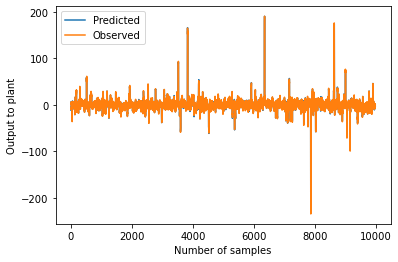

In [3]:
y_hat = np.matmul(w_optimal, window_filter_x)
print(y_hat.shape)
l1 = plt.plot(y_hat)
l2 = plt.plot(window_filter_y)
plt.legend(['Predicted', 'Observed'])
plt.xlabel('Number of samples')
plt.ylabel('Output to plant')
plt.show()

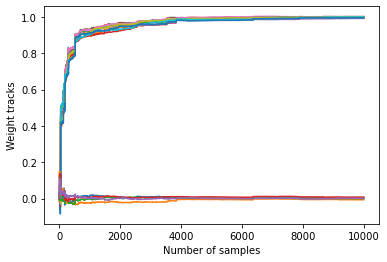

In [4]:
# weight
plt.plot(np.arange(len(weight_store)), weight_store)
plt.xlabel('Number of samples')
plt.ylabel('Weight tracks')
plt.show()

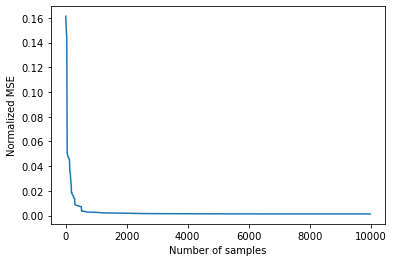

In [5]:
# error
plt.plot(np.arange(len(error_store)), error_store)
plt.xlabel('Number of samples')
plt.ylabel('Normalized MSE')
plt.show()